In [66]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [249]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [250]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 400
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  3.248394 seconds (7.47 M allocations: 6.639 GiB, 20.26% gc time, 56.56% compilation time)
Estimation of index coefs: 
̂α => [1.0; 1.1138184793180426]
̂γ => [0.11144081543702919, 0.7229071205172197]
Estimation of linear coefs: 
̂θ => [1.5289774733791228 -1.3727348771545511]
̂β => [0.8100138328431689, -0.5513043187558638]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

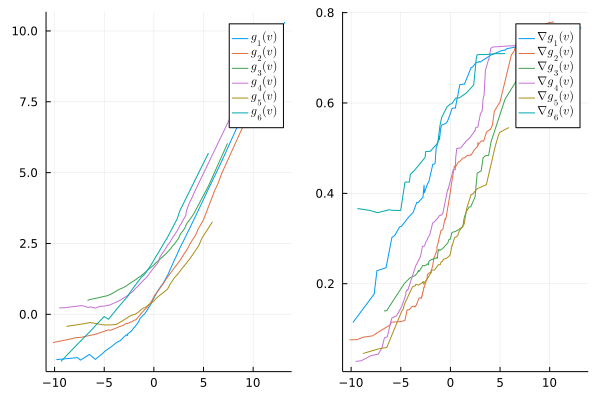

In [244]:
alphap = 1.0 * alpha1
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y - X * transpose(theta), 0.5, -0.4) # g: g(v), dg: g'(v)
p1 = plot()
p2 = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
plot(p1, p2, layout = (1,2))



# Monte Carlo Simulation

In [70]:
Threads.nthreads()

2

In [211]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [212]:
α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [1.0, -0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 200
fx = 2
dist = 1 # Cauchy
rep = 100 # MC rept. times

100

In [213]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:01<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:02<02:32, 2s/it]
3.0%┣█▍                                             ┫ 3/100 [00:02<01:29, 1it/s]
4.0%┣█▉                                             ┫ 4/100 [00:02<01:08, 1it/s]
5.0%┣██▍                                            ┫ 5/100 [00:02<00:56, 2it/s]
6.0%┣██▉                                            ┫ 6/100 [00:03<00:49, 2it/s]
7.0%┣███▎                                           ┫ 7/100 [00:03<00:44, 2it/s]
8.0%┣███▊                                           ┫ 8/100 [00:03<00:40, 2it/s]
9.0%┣████▎                                          ┫ 9/100 [00:03<00:37, 2it/s]
10.0%┣████▌                                        ┫ 10/100 [00:04<00:35, 3it/s]
11.0%┣█████                                        ┫ 11/100 [00:04<00:33, 3it/s]
12.0%┣█████▍                

([1.0 1.420937992749924; 1.0 2.426266364666491; … ; 1.0 1.8050547568109296; 1.0 1.8241247320161642], [0.9172898558263807 0.4372016220002707; 0.42665120648126287 0.6409172790663626; … ; -0.3346959190350609 0.2230158120445413; 0.1589815596190116 0.9770310039183601], [1.615682185554253 -1.1370532660805577; 2.1466576946682743 -0.8847576366428133; … ; 1.8564111660031444 -1.0284514411534795; 1.8533266655691554 -1.016008737253792], [0.6432675350736603 -0.43419160431090753; 0.5532235771551477 0.016474976580257806; … ; 0.7767439507846923 -0.1617061486090888; 0.6132662686705828 -0.3492123818988547])

In [214]:
mg = mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.327232  0.761487

In [215]:
(γ |> transpose) ./ mg

1×2 Matrix{Float64}:
 1.52797  1.31322

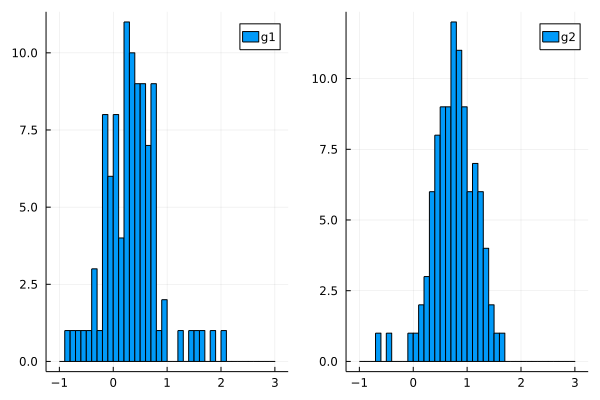

In [216]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [217]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 0.708323  -0.345875

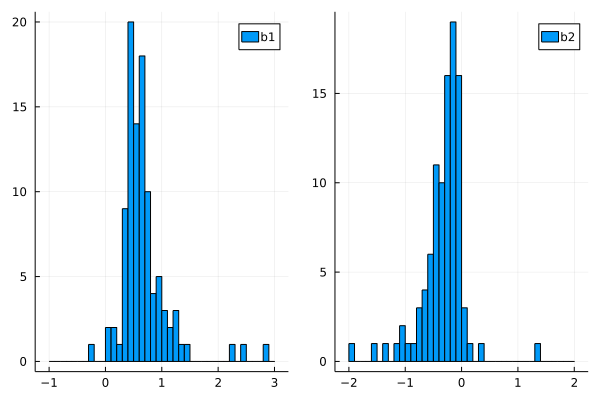

In [218]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

In [219]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 1.0  2.19354

In [220]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 1.91349  -0.978656

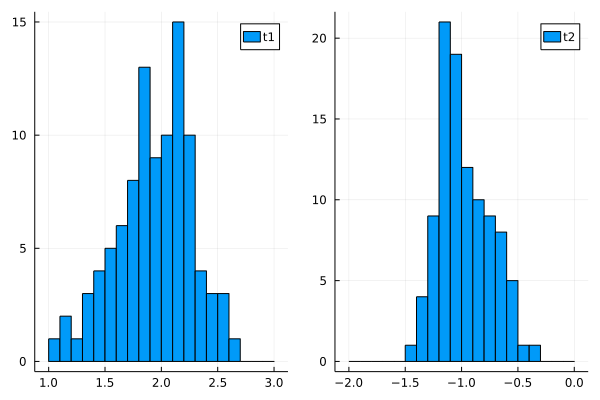

In [221]:
p1 = histogram(Theta[:,1], bins = 1:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

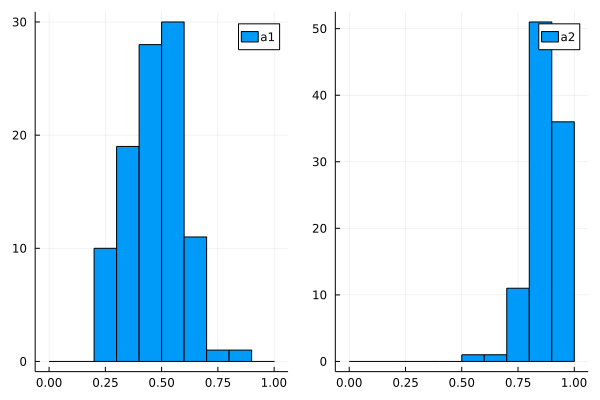

In [174]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))